<a href="https://colab.research.google.com/github/masatomo-ty/power_flow_calc/blob/master/page_rank_from_p2p_orders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:120: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:127: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:122: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: ComplexWarning: Casting complex values to real discards the imaginary part


    rank_0  rank_2  rank_4  rank_6  ...  rank_34  rank_36  rank_38  rank_40
20       8       8      15      15  ...        4        2        4        2
15       2       1       3       1  ...        1        4        3        3
31       9       3       6       5  ...        3        7       11        7
22      25      12      11       7  ...        7       11       24       30
13       7       2       4       4  ...        2        1        1        5
33       5       7       5      11  ...        5        8        5       15
24       6      10       7       9  ...        6        9        9        4
26      27      31      23      22  ...       33       16       34       33
30       1      20      18      12  ...       16       28       23       12
27      23      28      25      30  ...       34       23       18       17
4        3       6       1       2  ...       10        5        2        1
6       11       4       2       3  ...       19        3        6       18
10      21  

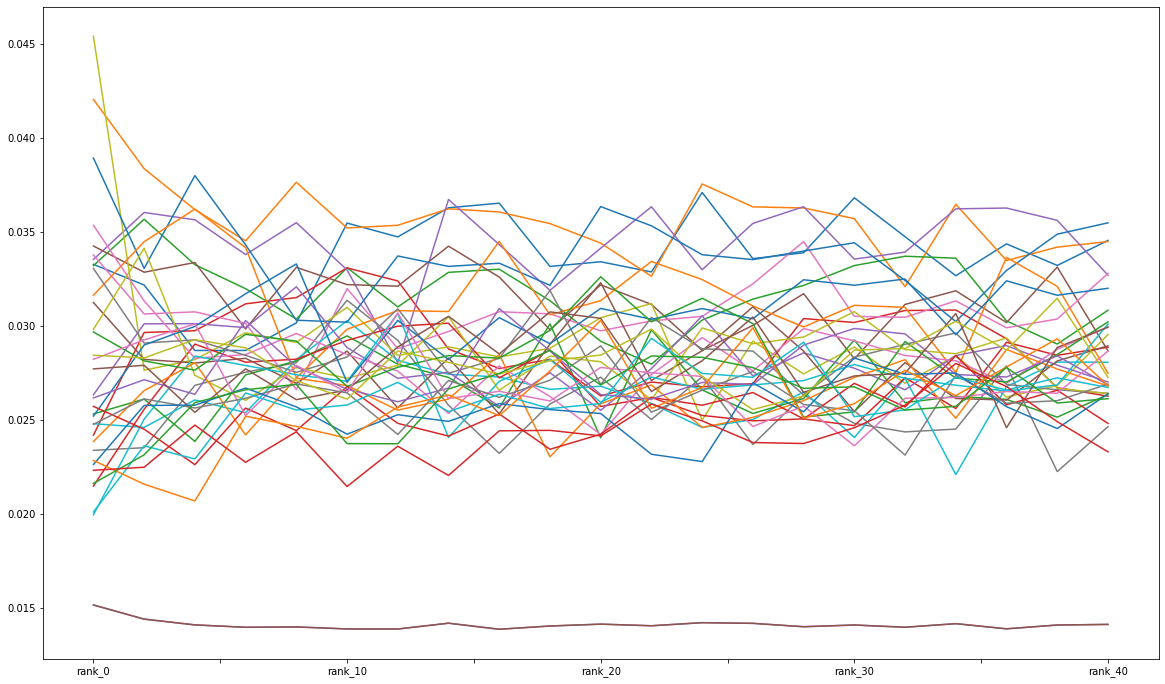

In [65]:
# -*- coding: utf-8 -*-
"""
潮流計算
全ノードPQ指定
"""

import numpy as np #行列のnpコード
import pandas as pd
import math
import random

# Import Feeder Data // NodeA to NodeB  D:距離　Load:負荷(消費)　PV:発電(需要) ############
df_line = pd.read_excel("feeder_case4.xlsx")

array_NodeA = df_line['NodeA'].to_numpy()
array_NodeB = df_line['NodeB'].to_numpy()
array_PV = df_line['PV'].to_numpy()
array_Battery = df_line['Battery'].to_numpy()

##########################################################

NODE_NUM = len(array_NodeA)

##負荷の値を入手
df_Loads = pd.read_csv("April_Load.csv", header=None) 
Loads = df_Loads.to_numpy()
Loads_PQ = np.zeros((NODE_NUM+1, ), dtype=np.complex128) #各母線の負荷によるPQ　a行=母線aのPQ消費

##PV出力の値を入手
df_PV = pd.read_csv("April_PV.csv", header=None) 
PV_profile = df_PV.to_numpy()
PV_out = np.zeros((NODE_NUM+1, ), dtype=np.complex128) #PV出力　a行=母線aのPVの出力

Stocks = np.zeros((NODE_NUM+1, ), dtype=np.complex128)
Orders = np.zeros((NODE_NUM, NODE_NUM), dtype=np.complex128)

result = pd.DataFrame(index=[])
result_by_rank = pd.DataFrame(index=[])

for loop in range(41):
    
    # if loop % 100 == 0:
    # print("loop=",loop)

    j = 0 #loadの数　j=0の時No.1の負荷を得る
    random.seed(loop)
    for time in range(1,len(df_Loads)+1):
    
        t = time

        for i in range(0,NODE_NUM):
            j = array_NodeB[i]
            Loads_PQ[array_NodeB[i]] = (Loads[t-1,j]*0.95 + 1j*Loads[t-1,j]*math.sqrt(1-0.95*0.95)) 

            if array_PV[i] == 1:
                PV_out[array_NodeB[i]] = PV_profile[t-1,j]*0.95 + 1j*PV_profile[t-1,j]*math.sqrt(1-0.95*0.95)

        Stocks = PV_out - Loads_PQ
        
        a0 = np.arange(0,NODE_NUM+1) # index [0]
        a1 = np.zeros((NODE_NUM+1, ), dtype=np.float64) # price [1]
        a2 = np.zeros((NODE_NUM+1, ), dtype=np.complex128) # amount [2]
        for i in range(0,NODE_NUM):
            if Stocks[i] > 0:
                if array_Battery[i] == 1:
                    a1[i] = random.uniform(3.5, 8.0)
                else:
                    a1[i] = random.uniform(1.0, 8.0)
                a2[i] = Stocks[i]
        
        a3 = np.zeros((NODE_NUM+1,)) # transaction result [3]
        a4 = np.stack([a0, a1, a2, a3], 1)
        Seller_Stock = sorted(a4, key=lambda x: x[1]) # [index, price, amount, result]

        b0 = np.arange(0,NODE_NUM+1) # index [0]
        b1 = np.zeros((NODE_NUM+1, ), dtype=np.float64) # price [1]
        b2 = np.zeros((NODE_NUM+1, ), dtype=np.complex128) # amount [2]
        for i in range(0,NODE_NUM):
            if Stocks[i] < 0:
                if array_Battery[i] == 1:
                  b1[i] = random.uniform(1.0, 8.0)
                  b2[i] = random.uniform(1.6, 2.0)
                else:
                  b1[i] = random.uniform(3.5, 8.0)
                  b2[i] = random.uniform(0.4, 2.0)

        b3 = np.zeros((NODE_NUM+1,)) # transaction result [3]
        b4 = np.stack([b0, b1, b2, b3], 1)
        Buyer_Needs = sorted(b4, reverse=True, key=lambda x: x[1]) # [index, price, amount, result]

        remain = 0
        remain_b = 0
        isFinal = False
        loopCount = 0
        for sell in Seller_Stock:
            loopCount = loopCount + 1
            if (sell[2] == 0j):
                    continue

            for buy in Buyer_Needs:
                if (buy[2] == 0j):
                    continue

                if (sell[1] <= buy[1]): # compare price
                    # print(sell[1], "<=", buy[1])
                    if (remain == 0):
                        remain = sell[2] - buy[2]
                        # print(remain, "=", sell[2], "-", buy[2])
                    elif (remain > 0):
                        remain_b = remain
                        remain = remain - buy[2]
                        # print(remain, "=", remain_b, "-", buy[2])
                    else:
                        remain_b = remain
                        remain = sell[2] + remain
                        # print(remain, "=", sell[2], "-", remain_b)
                    
                    if (remain >= 0):
                        if remain_b >= 0:
                            Orders[int(sell[0]), int(buy[0])] = buy[2]
                        else:
                            Orders[int(sell[0]), int(buy[0])] = - remain_b
                        buy[3] = buy[2]
                        buy[2] = 0
                    else:
                        if remain_b > 0:
                            Orders[int(sell[0]), int(buy[0])] = remain_b
                        else:
                            Orders[int(sell[0]), int(buy[0])] = sell[2]
                        if (loopCount == NODE_NUM+1):
                            buy[3] = buy[2] + remain
                        sell[3] = sell[2]
                        sell[2] = 0
                        break
                else:
                  if (not isFinal):
                      isFinal = True
                      if (remain >= 0):
                          sell[3] = sell[2] - remain
                      else:
                          buy[3] = buy[2] + remain
        
    PAGE_RANK_CALC_FOR = 2
    if loop % PAGE_RANK_CALC_FOR == 0:
        Orders = np.array(np.nan_to_num(Orders, nan=1), dtype=float)
        for i, order in enumerate(Orders):
            if order.sum() == 0:
                Orders[i] = np.ones((len(order), ))

        # np.savetxt(f'Orders.csv',Orders.real, delimiter=',')

        Rate = Orders.real.T/Orders.real.T.sum(axis = 0)
        # np.savetxt(f'Rate.csv',Rate, delimiter=',')

        x = np.array(Rate, dtype=float).T

        

        alpha = 0.85
        G = alpha * x + (1 - alpha) * np.ones((NODE_NUM,NODE_NUM)) / NODE_NUM
        np.savetxt(f'G.csv',G, delimiter=',')

        rank = np.array([1 for i in range(NODE_NUM)]) / NODE_NUM

        for i in range(20):
            rank = np.dot(rank,G)
            # if i % 4 == 0:
            #     print(rank)

        current_rank = pd.DataFrame({'rank': rank}).sort_values('rank', ascending=False).reset_index().sort_values('index')
        result_by_rank = pd.concat([result_by_rank, pd.Series(current_rank.index+1, name=f'rank_{loop}')], axis=1)
        result = pd.concat([result, pd.Series(rank, name=f'rank_{loop}')], axis=1)



print(result_by_rank.sort_values('rank_10')) # [node_num, (1,2...37)]

profile = pd.concat([pd.Series(array_PV, name='PV'), pd.Series(array_Battery, name='Battery')], axis=1)
print(pd.concat([result.sort_index(), profile], axis=1).sort_values('rank_10', ascending=False)) # [node_num, (0.xxx...0.xxx), PV, Battery)]

fin_result = result.sort_values('rank_10', ascending=False)
fin_result.to_csv('Rank.csv')

fin_result.T.plot(figsize=(20, 12), legend=False)

